In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [21]:
!du *

4	data/.ipynb_checkpoints
1404196	data
55508	sample_data
4	trained_model


In [20]:
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_amp_pha_10nm_full.npy?raw=true 
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_diff.npz?raw=true


In [22]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [23]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [24]:
EPOCHS = 60
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 64
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 1 Batch size: 64 Learning rate: 0.001


In [25]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

In [26]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [27]:
data_diffr = np.load('data/20191008_39_diff.npz')['arr_0']#np.load(path+'/../data/20191008_39_diff.npz')['arr_0']
real_space = np.load('data/20191008_39_amp_pha_10nm_full.npy')#np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [28]:
print(data_diffr.shape)
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), dtype=float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

(161, 161, 256, 256)


100%|██████████| 161/161 [00:54<00:00,  2.93it/s]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


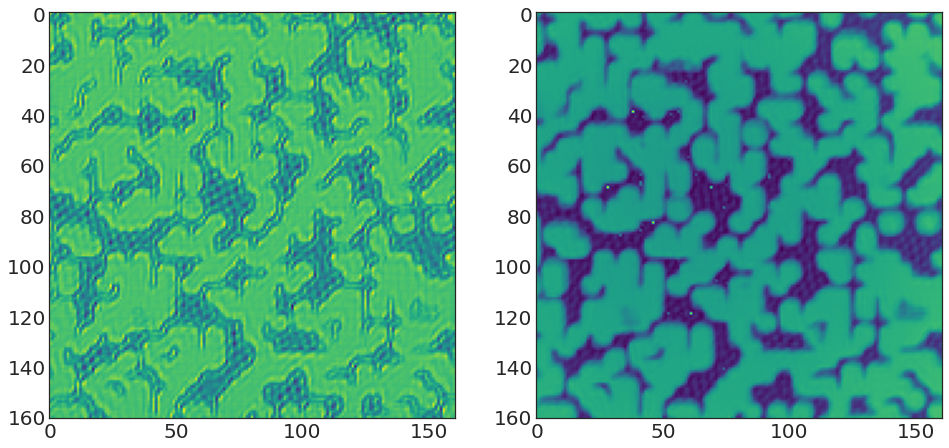

In [29]:
data_diffr_red32 = data_diffr_red#.astype('float32')
amp32 = amp#.astype('float32')
ph32 = ph#.astype('float32')
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(amp32[:,:,32,32])
ax[1].imshow(ph32[:,:,32,32])

In [30]:
tst_strt = amp32.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red32[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red32[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp32[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp32[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph32[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph32[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [31]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [32]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [33]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [34]:
nconv = 32


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            amp = self.decoder1(x1)
            ph = self.decoder2(x1)

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

In [35]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp, ph = model(ft_images)
    print(amp.shape, ph.shape)
    print(amp.dtype, ph.dtype)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


batch size: torch.Size([64, 1, 64, 64])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 64, 64])
torch.float32 torch.float32


In [36]:
summary(model,(1,H,W),device="cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           9,248
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          18,496
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
             ReLU-14          [-1, 128,

In [37]:
#Optimizer details
iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')

LR step size is: 1434.0 which is every 6 epochs


In [38]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

In [39]:
scaler = torch.cuda.amp.GradScaler()

In [40]:
def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_a + loss_p #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        scaler.update()
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        pred_amps, pred_phs = model(ft_images) #Forward pass
    
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [41]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

In [42]:

for epoch in range (EPOCHS):
    
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 

Saving improved model after Val Loss improved from inf to 0.66048
Epoch: 0 | FT  | Train Loss: 0.75632 | Val Loss: 0.66048
Epoch: 0 | Amp | Train Loss: 0.0921 | Val Loss: 0.0294
Epoch: 0 | Ph  | Train Loss: 0.664 | Val Loss: 0.631
Epoch: 0 | Ending LR: 0.000250 


239it [00:13, 17.63it/s]


Saving improved model after Val Loss improved from 0.66048 to 0.52842
Epoch: 1 | FT  | Train Loss: 0.55634 | Val Loss: 0.52842
Epoch: 1 | Amp | Train Loss: 0.0189 | Val Loss: 0.0229
Epoch: 1 | Ph  | Train Loss: 0.537 | Val Loss: 0.506
Epoch: 1 | Ending LR: 0.000400 


239it [00:13, 17.58it/s]


Saving improved model after Val Loss improved from 0.52842 to 0.46724
Epoch: 2 | FT  | Train Loss: 0.45671 | Val Loss: 0.46724
Epoch: 2 | Amp | Train Loss: 0.0143 | Val Loss: 0.0119
Epoch: 2 | Ph  | Train Loss: 0.442 | Val Loss: 0.455
Epoch: 2 | Ending LR: 0.000550 


239it [00:13, 17.43it/s]


Saving improved model after Val Loss improved from 0.46724 to 0.38531
Epoch: 3 | FT  | Train Loss: 0.39166 | Val Loss: 0.38531
Epoch: 3 | Amp | Train Loss: 0.0109 | Val Loss: 0.0109
Epoch: 3 | Ph  | Train Loss: 0.381 | Val Loss: 0.374
Epoch: 3 | Ending LR: 0.000700 


239it [00:14, 17.04it/s]


Saving improved model after Val Loss improved from 0.38531 to 0.36373
Epoch: 4 | FT  | Train Loss: 0.34485 | Val Loss: 0.36373
Epoch: 4 | Amp | Train Loss: 0.0073 | Val Loss: 0.0072
Epoch: 4 | Ph  | Train Loss: 0.338 | Val Loss: 0.356
Epoch: 4 | Ending LR: 0.000850 


239it [00:14, 16.88it/s]


Saving improved model after Val Loss improved from 0.36373 to 0.33089
Epoch: 5 | FT  | Train Loss: 0.31741 | Val Loss: 0.33089
Epoch: 5 | Amp | Train Loss: 0.0067 | Val Loss: 0.0070
Epoch: 5 | Ph  | Train Loss: 0.311 | Val Loss: 0.324
Epoch: 5 | Ending LR: 0.001000 


239it [00:14, 16.86it/s]


Saving improved model after Val Loss improved from 0.33089 to 0.29875
Epoch: 6 | FT  | Train Loss: 0.28700 | Val Loss: 0.29875
Epoch: 6 | Amp | Train Loss: 0.0064 | Val Loss: 0.0068
Epoch: 6 | Ph  | Train Loss: 0.281 | Val Loss: 0.292
Epoch: 6 | Ending LR: 0.000850 


239it [00:14, 16.61it/s]


Saving improved model after Val Loss improved from 0.29875 to 0.26759
Epoch: 7 | FT  | Train Loss: 0.25339 | Val Loss: 0.26759
Epoch: 7 | Amp | Train Loss: 0.0062 | Val Loss: 0.0066
Epoch: 7 | Ph  | Train Loss: 0.247 | Val Loss: 0.261
Epoch: 7 | Ending LR: 0.000700 


239it [00:14, 16.85it/s]


Saving improved model after Val Loss improved from 0.26759 to 0.24847
Epoch: 8 | FT  | Train Loss: 0.22421 | Val Loss: 0.24847
Epoch: 8 | Amp | Train Loss: 0.0061 | Val Loss: 0.0065
Epoch: 8 | Ph  | Train Loss: 0.218 | Val Loss: 0.242
Epoch: 8 | Ending LR: 0.000550 


239it [00:14, 16.77it/s]


Saving improved model after Val Loss improved from 0.24847 to 0.22157
Epoch: 9 | FT  | Train Loss: 0.19990 | Val Loss: 0.22157
Epoch: 9 | Amp | Train Loss: 0.0060 | Val Loss: 0.0064
Epoch: 9 | Ph  | Train Loss: 0.194 | Val Loss: 0.215
Epoch: 9 | Ending LR: 0.000400 


239it [00:14, 16.98it/s]


Saving improved model after Val Loss improved from 0.22157 to 0.20352
Epoch: 10 | FT  | Train Loss: 0.17703 | Val Loss: 0.20352
Epoch: 10 | Amp | Train Loss: 0.0059 | Val Loss: 0.0063
Epoch: 10 | Ph  | Train Loss: 0.171 | Val Loss: 0.197
Epoch: 10 | Ending LR: 0.000250 


239it [00:14, 16.91it/s]


Saving improved model after Val Loss improved from 0.20352 to 0.19061
Epoch: 11 | FT  | Train Loss: 0.15808 | Val Loss: 0.19061
Epoch: 11 | Amp | Train Loss: 0.0058 | Val Loss: 0.0063
Epoch: 11 | Ph  | Train Loss: 0.152 | Val Loss: 0.184
Epoch: 11 | Ending LR: 0.000100 


239it [00:14, 16.87it/s]


Saving improved model after Val Loss improved from 0.19061 to 0.18871
Epoch: 12 | FT  | Train Loss: 0.14823 | Val Loss: 0.18871
Epoch: 12 | Amp | Train Loss: 0.0057 | Val Loss: 0.0062
Epoch: 12 | Ph  | Train Loss: 0.142 | Val Loss: 0.182
Epoch: 12 | Ending LR: 0.000175 


239it [00:14, 16.67it/s]


Epoch: 13 | FT  | Train Loss: 0.14939 | Val Loss: 0.19139
Epoch: 13 | Amp | Train Loss: 0.0057 | Val Loss: 0.0062
Epoch: 13 | Ph  | Train Loss: 0.144 | Val Loss: 0.185
Epoch: 13 | Ending LR: 0.000250 


239it [00:14, 16.86it/s]


Epoch: 14 | FT  | Train Loss: 0.15416 | Val Loss: 0.19433
Epoch: 14 | Amp | Train Loss: 0.0057 | Val Loss: 0.0062
Epoch: 14 | Ph  | Train Loss: 0.148 | Val Loss: 0.188
Epoch: 14 | Ending LR: 0.000325 


239it [00:14, 16.78it/s]


Epoch: 15 | FT  | Train Loss: 0.15939 | Val Loss: 0.20273
Epoch: 15 | Amp | Train Loss: 0.0058 | Val Loss: 0.0062
Epoch: 15 | Ph  | Train Loss: 0.154 | Val Loss: 0.196
Epoch: 15 | Ending LR: 0.000400 


239it [00:14, 16.85it/s]


Epoch: 16 | FT  | Train Loss: 0.16311 | Val Loss: 0.20088
Epoch: 16 | Amp | Train Loss: 0.0058 | Val Loss: 0.0064
Epoch: 16 | Ph  | Train Loss: 0.157 | Val Loss: 0.194
Epoch: 16 | Ending LR: 0.000475 


239it [00:14, 16.98it/s]


Epoch: 17 | FT  | Train Loss: 0.16910 | Val Loss: 0.21761
Epoch: 17 | Amp | Train Loss: 0.0058 | Val Loss: 0.0062
Epoch: 17 | Ph  | Train Loss: 0.163 | Val Loss: 0.211
Epoch: 17 | Ending LR: 0.000550 


239it [00:14, 16.86it/s]


Epoch: 18 | FT  | Train Loss: 0.16467 | Val Loss: 0.19178
Epoch: 18 | Amp | Train Loss: 0.0057 | Val Loss: 0.0061
Epoch: 18 | Ph  | Train Loss: 0.159 | Val Loss: 0.186
Epoch: 18 | Ending LR: 0.000475 


239it [00:14, 16.81it/s]


Saving improved model after Val Loss improved from 0.18871 to 0.17904
Epoch: 19 | FT  | Train Loss: 0.15018 | Val Loss: 0.17904
Epoch: 19 | Amp | Train Loss: 0.0055 | Val Loss: 0.0060
Epoch: 19 | Ph  | Train Loss: 0.145 | Val Loss: 0.173
Epoch: 19 | Ending LR: 0.000400 


239it [00:14, 16.71it/s]


Saving improved model after Val Loss improved from 0.17904 to 0.16790
Epoch: 20 | FT  | Train Loss: 0.13704 | Val Loss: 0.16790
Epoch: 20 | Amp | Train Loss: 0.0054 | Val Loss: 0.0059
Epoch: 20 | Ph  | Train Loss: 0.132 | Val Loss: 0.162
Epoch: 20 | Ending LR: 0.000325 


239it [00:14, 16.89it/s]


Saving improved model after Val Loss improved from 0.16790 to 0.16059
Epoch: 21 | FT  | Train Loss: 0.12569 | Val Loss: 0.16059
Epoch: 21 | Amp | Train Loss: 0.0053 | Val Loss: 0.0058
Epoch: 21 | Ph  | Train Loss: 0.120 | Val Loss: 0.155
Epoch: 21 | Ending LR: 0.000250 


239it [00:14, 16.91it/s]


Saving improved model after Val Loss improved from 0.16059 to 0.15306
Epoch: 22 | FT  | Train Loss: 0.11688 | Val Loss: 0.15306
Epoch: 22 | Amp | Train Loss: 0.0052 | Val Loss: 0.0057
Epoch: 22 | Ph  | Train Loss: 0.112 | Val Loss: 0.147
Epoch: 22 | Ending LR: 0.000175 


239it [00:14, 16.88it/s]


Saving improved model after Val Loss improved from 0.15306 to 0.14801
Epoch: 23 | FT  | Train Loss: 0.10827 | Val Loss: 0.14801
Epoch: 23 | Amp | Train Loss: 0.0051 | Val Loss: 0.0057
Epoch: 23 | Ph  | Train Loss: 0.103 | Val Loss: 0.142
Epoch: 23 | Ending LR: 0.000100 


239it [00:14, 16.77it/s]


Epoch: 24 | FT  | Train Loss: 0.10370 | Val Loss: 0.14833
Epoch: 24 | Amp | Train Loss: 0.0050 | Val Loss: 0.0056
Epoch: 24 | Ph  | Train Loss: 0.099 | Val Loss: 0.143
Epoch: 24 | Ending LR: 0.000138 


239it [00:14, 16.86it/s]


Epoch: 25 | FT  | Train Loss: 0.10442 | Val Loss: 0.14946
Epoch: 25 | Amp | Train Loss: 0.0050 | Val Loss: 0.0056
Epoch: 25 | Ph  | Train Loss: 0.099 | Val Loss: 0.144
Epoch: 25 | Ending LR: 0.000175 


239it [00:14, 16.68it/s]


Epoch: 26 | FT  | Train Loss: 0.10683 | Val Loss: 0.15199
Epoch: 26 | Amp | Train Loss: 0.0050 | Val Loss: 0.0057
Epoch: 26 | Ph  | Train Loss: 0.102 | Val Loss: 0.146
Epoch: 26 | Ending LR: 0.000213 


239it [00:14, 16.63it/s]


Epoch: 27 | FT  | Train Loss: 0.11018 | Val Loss: 0.15322
Epoch: 27 | Amp | Train Loss: 0.0050 | Val Loss: 0.0057
Epoch: 27 | Ph  | Train Loss: 0.105 | Val Loss: 0.148
Epoch: 27 | Ending LR: 0.000250 


239it [00:14, 16.74it/s]


Epoch: 28 | FT  | Train Loss: 0.11500 | Val Loss: 0.15634
Epoch: 28 | Amp | Train Loss: 0.0050 | Val Loss: 0.0056
Epoch: 28 | Ph  | Train Loss: 0.110 | Val Loss: 0.151
Epoch: 28 | Ending LR: 0.000287 


239it [00:14, 16.66it/s]


Epoch: 29 | FT  | Train Loss: 0.11915 | Val Loss: 0.15929
Epoch: 29 | Amp | Train Loss: 0.0050 | Val Loss: 0.0056
Epoch: 29 | Ph  | Train Loss: 0.114 | Val Loss: 0.154
Epoch: 29 | Ending LR: 0.000325 


239it [00:14, 16.88it/s]


Epoch: 30 | FT  | Train Loss: 0.11783 | Val Loss: 0.15671
Epoch: 30 | Amp | Train Loss: 0.0049 | Val Loss: 0.0056
Epoch: 30 | Ph  | Train Loss: 0.113 | Val Loss: 0.151
Epoch: 30 | Ending LR: 0.000287 


239it [00:14, 16.87it/s]


Saving improved model after Val Loss improved from 0.14801 to 0.14757
Epoch: 31 | FT  | Train Loss: 0.11045 | Val Loss: 0.14757
Epoch: 31 | Amp | Train Loss: 0.0048 | Val Loss: 0.0054
Epoch: 31 | Ph  | Train Loss: 0.106 | Val Loss: 0.142
Epoch: 31 | Ending LR: 0.000250 


239it [00:14, 16.81it/s]


Saving improved model after Val Loss improved from 0.14757 to 0.14294
Epoch: 32 | FT  | Train Loss: 0.10423 | Val Loss: 0.14294
Epoch: 32 | Amp | Train Loss: 0.0047 | Val Loss: 0.0053
Epoch: 32 | Ph  | Train Loss: 0.100 | Val Loss: 0.138
Epoch: 32 | Ending LR: 0.000213 


239it [00:14, 16.56it/s]


Saving improved model after Val Loss improved from 0.14294 to 0.13984
Epoch: 33 | FT  | Train Loss: 0.09877 | Val Loss: 0.13984
Epoch: 33 | Amp | Train Loss: 0.0045 | Val Loss: 0.0053
Epoch: 33 | Ph  | Train Loss: 0.094 | Val Loss: 0.135
Epoch: 33 | Ending LR: 0.000175 


239it [00:14, 16.79it/s]


Saving improved model after Val Loss improved from 0.13984 to 0.13667
Epoch: 34 | FT  | Train Loss: 0.09335 | Val Loss: 0.13667
Epoch: 34 | Amp | Train Loss: 0.0044 | Val Loss: 0.0052
Epoch: 34 | Ph  | Train Loss: 0.089 | Val Loss: 0.131
Epoch: 34 | Ending LR: 0.000138 


239it [00:14, 16.74it/s]


Saving improved model after Val Loss improved from 0.13667 to 0.13451
Epoch: 35 | FT  | Train Loss: 0.08883 | Val Loss: 0.13451
Epoch: 35 | Amp | Train Loss: 0.0043 | Val Loss: 0.0051
Epoch: 35 | Ph  | Train Loss: 0.084 | Val Loss: 0.129
Epoch: 35 | Ending LR: 0.000100 


239it [00:14, 16.82it/s]


Epoch: 36 | FT  | Train Loss: 0.08646 | Val Loss: 0.13467
Epoch: 36 | Amp | Train Loss: 0.0043 | Val Loss: 0.0051
Epoch: 36 | Ph  | Train Loss: 0.082 | Val Loss: 0.130
Epoch: 36 | Ending LR: 0.000119 


239it [00:14, 16.87it/s]


Epoch: 37 | FT  | Train Loss: 0.08690 | Val Loss: 0.13458
Epoch: 37 | Amp | Train Loss: 0.0043 | Val Loss: 0.0051
Epoch: 37 | Ph  | Train Loss: 0.083 | Val Loss: 0.129
Epoch: 37 | Ending LR: 0.000137 


239it [00:14, 16.89it/s]


Epoch: 38 | FT  | Train Loss: 0.08864 | Val Loss: 0.13649
Epoch: 38 | Amp | Train Loss: 0.0043 | Val Loss: 0.0052
Epoch: 38 | Ph  | Train Loss: 0.084 | Val Loss: 0.131
Epoch: 38 | Ending LR: 0.000156 


239it [00:14, 16.73it/s]


Epoch: 39 | FT  | Train Loss: 0.09064 | Val Loss: 0.13916
Epoch: 39 | Amp | Train Loss: 0.0043 | Val Loss: 0.0051
Epoch: 39 | Ph  | Train Loss: 0.086 | Val Loss: 0.134
Epoch: 39 | Ending LR: 0.000175 


239it [00:14, 16.79it/s]


Epoch: 40 | FT  | Train Loss: 0.09252 | Val Loss: 0.13883
Epoch: 40 | Amp | Train Loss: 0.0043 | Val Loss: 0.0053
Epoch: 40 | Ph  | Train Loss: 0.088 | Val Loss: 0.134
Epoch: 40 | Ending LR: 0.000194 


239it [00:14, 16.92it/s]


Epoch: 41 | FT  | Train Loss: 0.09385 | Val Loss: 0.13940
Epoch: 41 | Amp | Train Loss: 0.0043 | Val Loss: 0.0051
Epoch: 41 | Ph  | Train Loss: 0.090 | Val Loss: 0.134
Epoch: 41 | Ending LR: 0.000213 


239it [00:14, 16.85it/s]


Epoch: 42 | FT  | Train Loss: 0.09440 | Val Loss: 0.13747
Epoch: 42 | Amp | Train Loss: 0.0043 | Val Loss: 0.0051
Epoch: 42 | Ph  | Train Loss: 0.090 | Val Loss: 0.132
Epoch: 42 | Ending LR: 0.000194 


239it [00:14, 16.77it/s]


Saving improved model after Val Loss improved from 0.13451 to 0.13397
Epoch: 43 | FT  | Train Loss: 0.09058 | Val Loss: 0.13397
Epoch: 43 | Amp | Train Loss: 0.0042 | Val Loss: 0.0050
Epoch: 43 | Ph  | Train Loss: 0.086 | Val Loss: 0.129
Epoch: 43 | Ending LR: 0.000175 


239it [00:14, 16.68it/s]


Saving improved model after Val Loss improved from 0.13397 to 0.13241
Epoch: 44 | FT  | Train Loss: 0.08752 | Val Loss: 0.13241
Epoch: 44 | Amp | Train Loss: 0.0041 | Val Loss: 0.0050
Epoch: 44 | Ph  | Train Loss: 0.083 | Val Loss: 0.127
Epoch: 44 | Ending LR: 0.000156 


239it [00:14, 16.87it/s]


Saving improved model after Val Loss improved from 0.13241 to 0.13157
Epoch: 45 | FT  | Train Loss: 0.08439 | Val Loss: 0.13157
Epoch: 45 | Amp | Train Loss: 0.0041 | Val Loss: 0.0050
Epoch: 45 | Ph  | Train Loss: 0.080 | Val Loss: 0.127
Epoch: 45 | Ending LR: 0.000137 


239it [00:14, 16.87it/s]


Saving improved model after Val Loss improved from 0.13157 to 0.13002
Epoch: 46 | FT  | Train Loss: 0.08163 | Val Loss: 0.13002
Epoch: 46 | Amp | Train Loss: 0.0040 | Val Loss: 0.0050
Epoch: 46 | Ph  | Train Loss: 0.078 | Val Loss: 0.125
Epoch: 46 | Ending LR: 0.000119 


239it [00:14, 16.87it/s]


Saving improved model after Val Loss improved from 0.13002 to 0.12944
Epoch: 47 | FT  | Train Loss: 0.07933 | Val Loss: 0.12944
Epoch: 47 | Amp | Train Loss: 0.0039 | Val Loss: 0.0049
Epoch: 47 | Ph  | Train Loss: 0.075 | Val Loss: 0.125
Epoch: 47 | Ending LR: 0.000100 


239it [00:14, 16.71it/s]


Epoch: 48 | FT  | Train Loss: 0.07796 | Val Loss: 0.12963
Epoch: 48 | Amp | Train Loss: 0.0039 | Val Loss: 0.0049
Epoch: 48 | Ph  | Train Loss: 0.074 | Val Loss: 0.125
Epoch: 48 | Ending LR: 0.000109 


239it [00:14, 16.77it/s]


Epoch: 49 | FT  | Train Loss: 0.07845 | Val Loss: 0.12993
Epoch: 49 | Amp | Train Loss: 0.0039 | Val Loss: 0.0049
Epoch: 49 | Ph  | Train Loss: 0.075 | Val Loss: 0.125
Epoch: 49 | Ending LR: 0.000119 


239it [00:14, 16.84it/s]


Epoch: 50 | FT  | Train Loss: 0.07908 | Val Loss: 0.13022
Epoch: 50 | Amp | Train Loss: 0.0039 | Val Loss: 0.0049
Epoch: 50 | Ph  | Train Loss: 0.075 | Val Loss: 0.125
Epoch: 50 | Ending LR: 0.000128 


239it [00:14, 16.92it/s]


Epoch: 51 | FT  | Train Loss: 0.08003 | Val Loss: 0.13083
Epoch: 51 | Amp | Train Loss: 0.0039 | Val Loss: 0.0050
Epoch: 51 | Ph  | Train Loss: 0.076 | Val Loss: 0.126
Epoch: 51 | Ending LR: 0.000137 


239it [00:14, 16.75it/s]


Epoch: 52 | FT  | Train Loss: 0.08175 | Val Loss: 0.13235
Epoch: 52 | Amp | Train Loss: 0.0039 | Val Loss: 0.0049
Epoch: 52 | Ph  | Train Loss: 0.078 | Val Loss: 0.127
Epoch: 52 | Ending LR: 0.000147 


239it [00:14, 16.68it/s]


Epoch: 53 | FT  | Train Loss: 0.08173 | Val Loss: 0.13158
Epoch: 53 | Amp | Train Loss: 0.0039 | Val Loss: 0.0050
Epoch: 53 | Ph  | Train Loss: 0.078 | Val Loss: 0.127
Epoch: 53 | Ending LR: 0.000156 


239it [00:14, 16.82it/s]


Epoch: 54 | FT  | Train Loss: 0.08183 | Val Loss: 0.13091
Epoch: 54 | Amp | Train Loss: 0.0039 | Val Loss: 0.0050
Epoch: 54 | Ph  | Train Loss: 0.078 | Val Loss: 0.126
Epoch: 54 | Ending LR: 0.000147 


239it [00:14, 16.88it/s]


Epoch: 55 | FT  | Train Loss: 0.08006 | Val Loss: 0.13006
Epoch: 55 | Amp | Train Loss: 0.0039 | Val Loss: 0.0049
Epoch: 55 | Ph  | Train Loss: 0.076 | Val Loss: 0.125
Epoch: 55 | Ending LR: 0.000137 


239it [00:14, 16.73it/s]


Saving improved model after Val Loss improved from 0.12944 to 0.12917
Epoch: 56 | FT  | Train Loss: 0.07812 | Val Loss: 0.12917
Epoch: 56 | Amp | Train Loss: 0.0038 | Val Loss: 0.0049
Epoch: 56 | Ph  | Train Loss: 0.074 | Val Loss: 0.124
Epoch: 56 | Ending LR: 0.000128 


239it [00:14, 16.75it/s]


Saving improved model after Val Loss improved from 0.12917 to 0.12845
Epoch: 57 | FT  | Train Loss: 0.07672 | Val Loss: 0.12845
Epoch: 57 | Amp | Train Loss: 0.0038 | Val Loss: 0.0048
Epoch: 57 | Ph  | Train Loss: 0.073 | Val Loss: 0.124
Epoch: 57 | Ending LR: 0.000119 


239it [00:14, 16.79it/s]


Saving improved model after Val Loss improved from 0.12845 to 0.12830
Epoch: 58 | FT  | Train Loss: 0.07522 | Val Loss: 0.12830
Epoch: 58 | Amp | Train Loss: 0.0037 | Val Loss: 0.0048
Epoch: 58 | Ph  | Train Loss: 0.071 | Val Loss: 0.123
Epoch: 58 | Ending LR: 0.000109 


239it [00:14, 16.72it/s]


Saving improved model after Val Loss improved from 0.12830 to 0.12632
Epoch: 59 | FT  | Train Loss: 0.07406 | Val Loss: 0.12632
Epoch: 59 | Amp | Train Loss: 0.0037 | Val Loss: 0.0048
Epoch: 59 | Ph  | Train Loss: 0.070 | Val Loss: 0.122
Epoch: 59 | Ending LR: 0.000100 


Text(0.5, 0, 'Epoch')

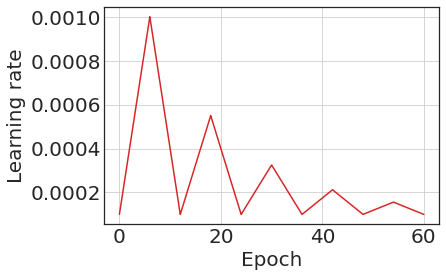

In [43]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

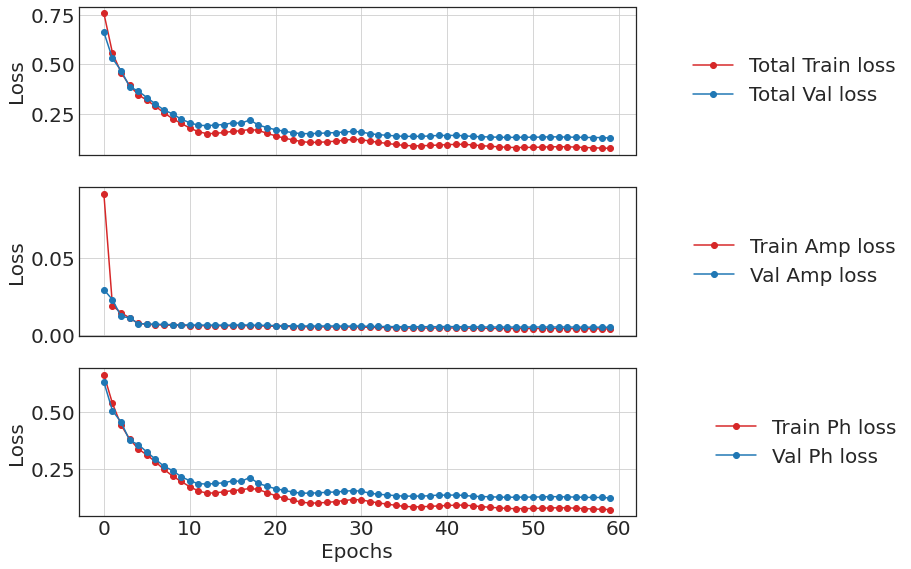

In [44]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [47]:
model.eval() #imp when have dropout etc
amps = []
phs = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp, ph = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps.append(amp[j].detach().to("cpu").numpy())
        phs.append(ph[j].detach().to("cpu").numpy())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [48]:
amps = np.array(amps).squeeze()
phs = np.array(phs).squeeze()
print(amps.shape, amps.dtype)
print(phs.shape, phs.dtype)

(3600, 64, 64) float16
(3600, 64, 64) float16


<Figure size 432x288 with 0 Axes>

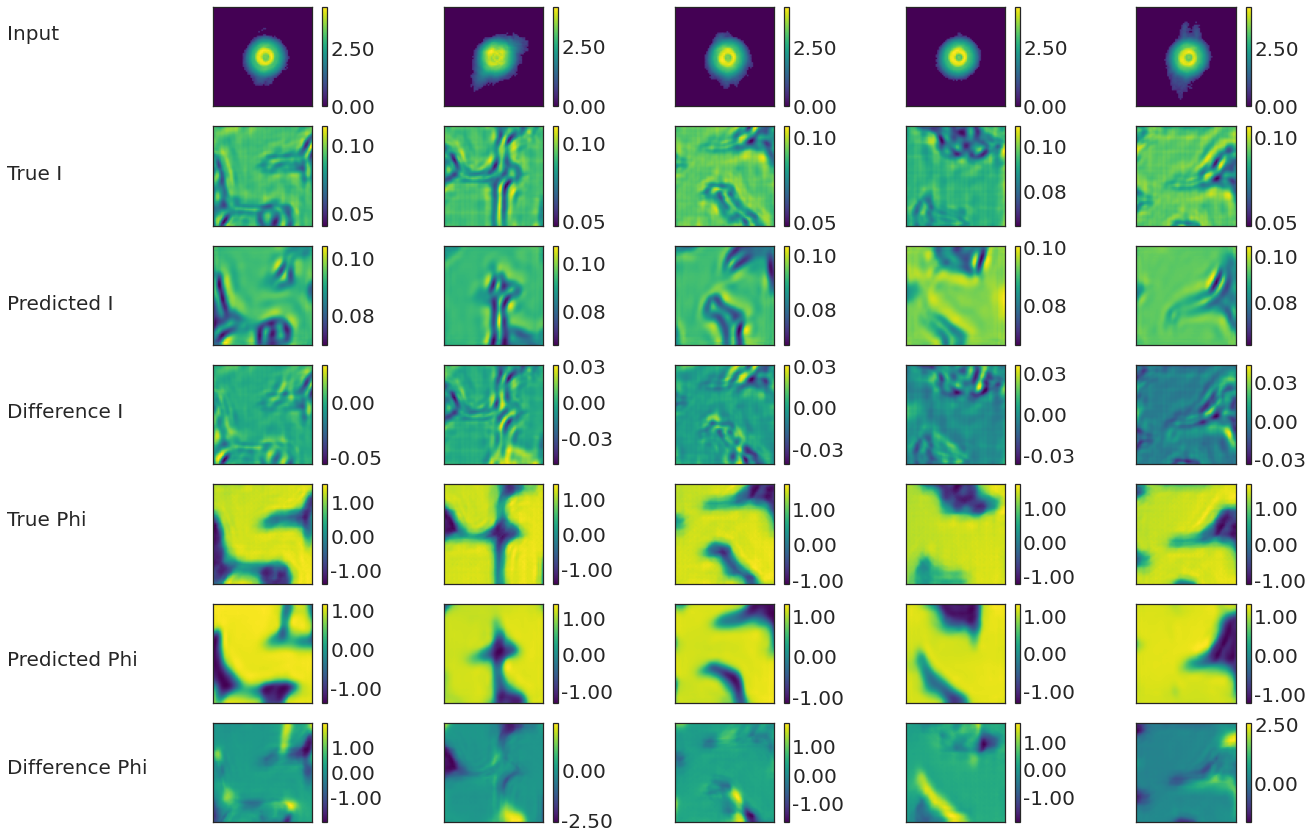

In [49]:
h,w = 64,64
ntest=amps.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT

    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-amps[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w)-phs[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [50]:
point_size = 3
overlap = 4*point_size

In [51]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [52]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [53]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [54]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


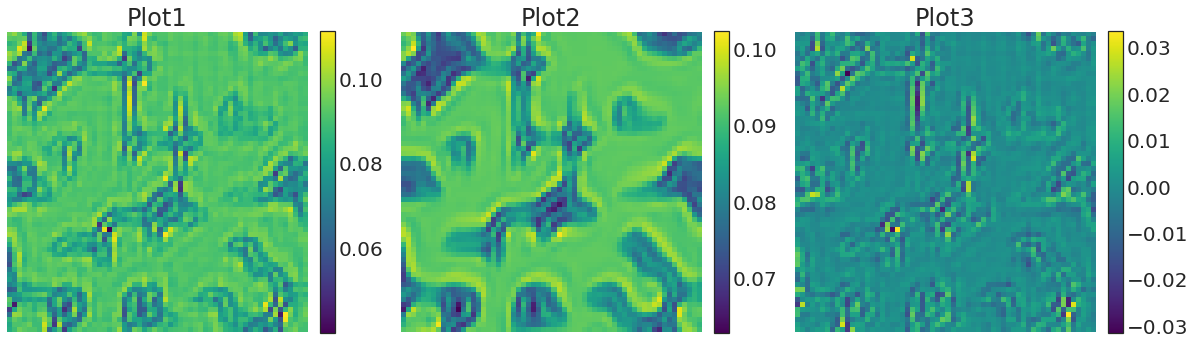

In [55]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

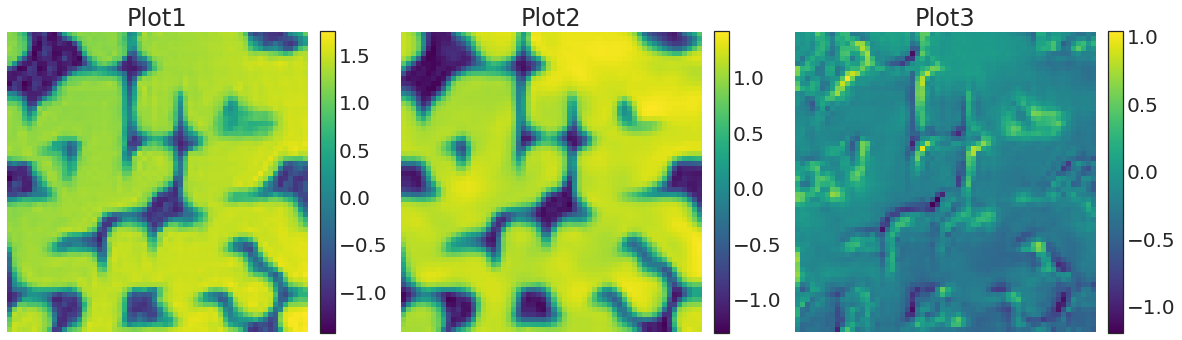

In [56]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [57]:
from sklearn.metrics import mean_squared_error as mse
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  3.8333165905335857e-05
MSE in phase:  0.0838614002068867


In [49]:
from sklearn.metrics import mean_squared_error as mse
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  4.011137771785222e-05
MSE in phase:  0.09132668446752414
